In [197]:
import pandas as pd
import numpy as np
import os
import re
import io
import functools
import math
from sklearn.cluster import *
import matplotlib.pyplot as plt

In [340]:
k = 4
l = math.ceil(math.log(k, 2))

w = 500

low = 0.01
high = 0.05

In [314]:
def standardize(word):
    word = word.lower()
    return word
    
def create_dict(text_documents):
    dictionary = []
    for doc in text_documents:
        lines = doc.split("\n")
        for line in lines:
            words = re.split('[,.;:!? \t(){}]', line)
            for i, word in enumerate(words):
                if i >= w:
                    break
                word = standardize(word)
                if word == '':
                    continue
                if word not in dictionary:
                    dictionary.append(word)
    return dictionary

def text_features_extractor(text):
    features = dict(zip(dictionary, np.zeros(len(dictionary), dtype='int')))
    keys = features.keys()
    lines = text.split("\n")
    for line in lines:
        words = re.split('[,.;:!? \t]', line)
        for i, word in enumerate(words):
            if i >= w:
                    break
            word = standardize(word)
            if word in keys:
                features[word] += 1
    return list(features.values())

In [315]:
category_names = ['crypto', 'travel', 'cooking', 'robotics']
data = None
for name in category_names:
    new = pd.read_csv('input/' + name + '.csv').iloc[:300, :]
    new['Labels'] = np.full(new.shape[0], name)
    if data is None:
        data = new
    else:
        data = pd.concat([data, new], axis=0)

In [316]:
import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer



In [317]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\38595\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [318]:
stops = set(stopwords.words("english"))

In [319]:
def clean_content(table):
    content = table.content
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Tokenizing data
    #content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    #content = content.apply(lambda x: [i for i in x if i not in stops])
    return(content)

data['content'] = clean_content(data) 

In [320]:
num_articles = data.shape[0]
num_labels = data['Labels'].nunique()
labels = data['Labels']
labels_head = np.unique(labels.to_numpy())

def identity_tokenizer(text):
  return text
#vect = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
#A = vect.fit_transform(data['content'].values)

In [321]:
num_articles = data.shape[0]
num_labels = data['Labels'].nunique()
labels = data['Labels']
labels_head = np.unique(labels.to_numpy())
dictionary = create_dict(data['content'])

In [322]:
#A = np.transpose(A.A)

In [323]:
len(data)

1200

In [324]:
len(dictionary)
#dictionary

9521

In [325]:
#index
A = data['content'].apply(lambda row: text_features_extractor(row)).values.tolist()
A = np.transpose(A)
# print(A)

In [326]:
A = np.array(A)
print(A.shape)

(9521, 1200)


In [327]:
# filtracija A, izbacivanje rijetkih i cestih rijeci
df = pd.DataFrame(A)
df2 = df.applymap(lambda x: 1 if x != 0 else 0)
counts = list(df2.apply(lambda x: sum(x) / len(labels), axis=1))
selected = [low < count < high for count in counts]
df['words'] = dictionary
df = df.loc[selected, :]
wordsmap = df['words']
wordsmap = wordsmap.reset_index()
df = df.drop(['words'], axis = 1)
A = df.to_numpy()
#print(A)

In [341]:
D1_diag = np.sum(A, axis=1)
D1 = np.diag(D1_diag)

In [342]:
D2_diag = np.sum(A, axis=0)
D2 = np.diag(D2_diag)

In [343]:
D1_inv = np.diag(list(map(lambda x: 0 if x == 0 else 1/(np.sqrt(x)), D1_diag)))
D2_inv = np.diag(list(map(lambda x: 0 if x == 0 else 1/(np.sqrt(x)), D2_diag)))

In [344]:
An = D1_inv @ A @ D2_inv

In [345]:
u, s, vt = np.linalg.svd(An)
v = np.transpose(vt)

In [346]:
U = u[:, 1:(1+l)]
V = v[:, 1:(1+l)]
print(U.shape)
print(V.shape)

(728, 2)
(1200, 2)


In [347]:
Z = np.block([[D1_inv @ U], [D2_inv @ V]])
# Z = Z.tolist()
# Z = list(map(lambda t: t[0], Z))
# # print(Z)
# Z = np.array(Z).reshape(-1, 1)

In [348]:
kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
kmeans.fit(Z)
predictions = kmeans.predict(Z)

In [349]:
table = np.zeros((k, num_labels), dtype='int')
table = pd.DataFrame(table, columns=labels_head)


for i, pred in enumerate(predictions[-num_articles:]):
    label = labels.iloc[i]
#     print("{}-{}".format(pred, label))
    table[label][pred] += 1
print(table)

   cooking  crypto  robotics  travel
0        3     230         2       0
1       58      61       136      71
2        0       7       161       4
3      239       2         1     225


In [350]:
predictions_words = predictions[0:-num_articles]
predictions_docs = predictions[-num_articles:]

In [351]:
for i in range(k):
    print('klaster {}'.format(i))
    selected = predictions_docs == i
    B = pd.DataFrame(A)
    B=B.iloc[:, selected]
    B['weight'] = B.sum(axis = 1, skipna = True)
    B_sorted = B.sort_values(by='weight', ascending=False)
    print(wordsmap.iloc[B_sorted.index[0:10]])

klaster 0
     index     words
14      62      hash
5       32         n
185    527         k
28     113    cipher
78     239         g
72     227       aes
396   1221         x
7       38   message
17      76  function
179    507         c
klaster 1
     index     words
716   7274    robots
551   2323     build
522   2011   program
233    650     point
489   1709      line
305    894       set
714   7266  robotics
386   1192     might
42     142      code
426   1366       far
klaster 2
     index    words
164    478        0
396   1221        x
718   7315    motor
515   1972      amp
531   2102  control
709   7225   motors
469   1602        y
710   7226   servos
713   7244    servo
720   7383   torque
klaster 3
     index      words
637   4023       visa
636   4012     travel
626   3947       trip
205    594         us
690   5941    cooking
487   1694      visit
696   5960     recipe
618   3641    country
121    346      heard
641   4041  countries


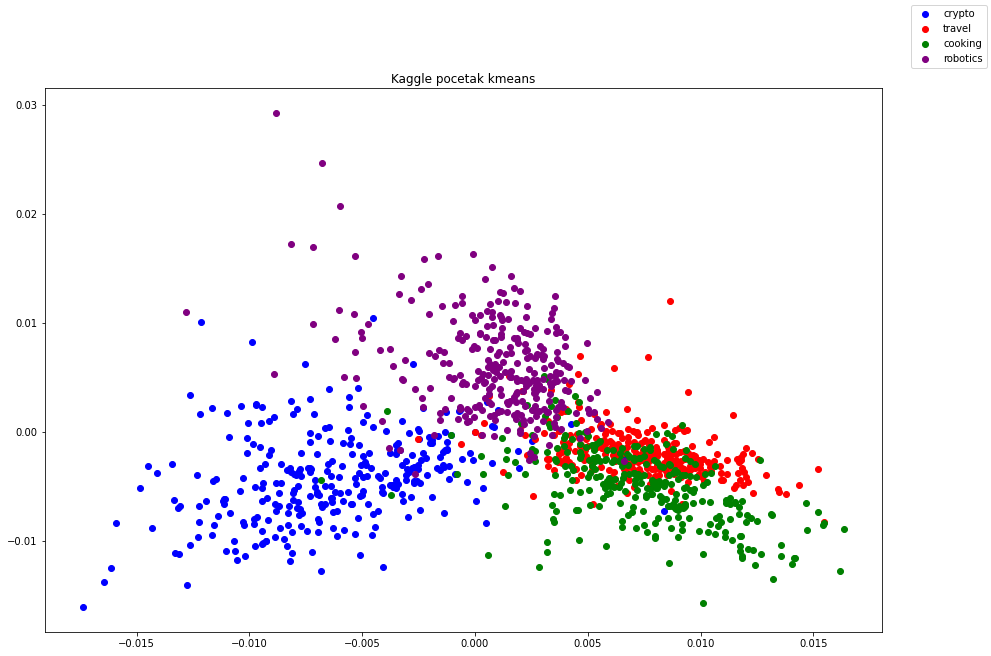

In [359]:
fig = plt.figure(figsize=(15, 10))
plt.title("Kaggle pocetak kmeans")
labels2 = labels.to_numpy()
first = labels2[labels2=='crypto']
plt.scatter(Z[-num_articles:-num_articles+len(first), 0], Z[-num_articles:-num_articles+len(first), 1], color='blue')
second = labels2[labels2=='travel']
plt.scatter(Z[-num_articles+len(first):-num_articles+len(first)+len(second), 0], Z[-num_articles+len(first):-num_articles+len(first)+len(second), 1], color='red')
third = labels2[labels2=='cooking']
plt.scatter(Z[-num_articles+len(first)+len(second):-num_articles+len(first)+len(second)+len(third), 0], Z[-num_articles+len(first)+len(second):-num_articles+len(first)+len(second)+len(third), 1], color='green')
plt.scatter(Z[-num_articles+len(first)+len(second)+len(third):, 0], Z[-num_articles+len(first)+len(second)+len(third):, 1], color='purple')
# plt.scatter(Z[-num_articles:-num_articles+len(first), :], color='blue')
# plt.scatter(Z[-num_articles+len(first):, :], np.zeros(num_articles-len(first)), color='red')
fig.legend(['crypto', 'travel', 'cooking', 'robotics'])
# if len(pred_false) > 0:
#     plt.scatter(pred_false[:,0], pred_false[:, 1], color='red')
plt.savefig('kaggle.png')
plt.show()

In [353]:
labels

0        crypto
1        crypto
2        crypto
3        crypto
4        crypto
         ...   
295    robotics
296    robotics
297    robotics
298    robotics
299    robotics
Name: Labels, Length: 1200, dtype: object